# Experimental Analysis of Different Restart Policies in *Sat4j-RoundingSat*

This document provides a complete analysis of the performance of the pseudo-Boolean solver *Sat4j-RoundingSat* in which different restart policies have been implemented.

By default, this document is **not** dynamic, so as to be readable on GitLab.
You may switch to a dynamic document by setting the following variable to `True`, and re-run this Jupyter Notebook (the serialized results of the campaign are also available in this directory).
Note that the [*latest version of Metrics*](https://pypi.org/project/crillab-metrics/) must be installed in your environment to run this notebook.

In [1]:
dynamic = False
figsize = (10, 7)

## Loading the experiments

First, let us load the experiments with *Metrics*.
We note that an experiment will be considered as successfull when the solver has been able to decide whether the input formula is `SATISFIABLE` or `UNSATISFIABLE`.
Otherwise, the solver did not have enough time to decide the satisfiability of the formula, and either outputed `UNKNOWN` or nothing (if it did not have enough time to handle the `SIGTERM` signal).

In [2]:
from os import path
from pandas import isnull
from metrics.wallet import Analysis, import_analysis

In [3]:
campaign_name = 'sat4j-roundingsat-restart'

if path.exists(f'{campaign_name}.json'):
    # Loading the serialized campaign.
    with open(f'{campaign_name}.json') as json_analysis:
        sat4j_restart = import_analysis(json_analysis.read())

else:
    # Extracting the campaign from the log files of the experiments, and serializing it for later use.
    sat4j_restart = Analysis(f'{campaign_name}.yml',
                             is_success=lambda xp: xp['decision'] in ('SATISFIABLE', 'UNSATISFIABLE'))
    with open(f'{campaign_name}.json', 'w') as json_analysis:
        json_analysis.write(sat4j_restart.export())

Let us now fix some issues with the columns `nbConflicts` and `nbResolutions`.
For these columns, data may be missing as the solver may not have enough time to handle the `SIGTERM` signal.
This is not a problem, as this means that the solver reached the timeout anyway, and this number would not reflect anything regarding the size of the proof built by the solver, as the proof is not completed.
The only reason we need to fix these columns is that the missing values lead to an incorrect inferrence of the type of the values in the column, so we simply ensure that the value is an integer, or `None` if the value is missing.

In [4]:
def to_int(row, column):
    if isnull(row[column]):
        return None
    if type(row[column]) in (int, float):
        return int(row[column])
    if row[column]:
        return int(row[column])
    return None
    
sat4j_restart = sat4j_restart.map(new_col='conflicts', function=lambda x: to_int(x, 'nbConflicts'))
sat4j_restart = sat4j_restart.map(new_col='steps', function=lambda x: to_int(x, 'nbResolutions'))

We now keep the list of all the considered solvers to easily retrieve them later on.

In [5]:
all_solvers = sat4j_restart.campaign_df.xp_ware_names

In [6]:
solver_map = {
    'default': 'picosat - activity',
    'restart-effective': 'lbd-e',
    'restart-degree': 'degree',
    'restart-luby-nodelete': 'luby - no-delete',
    'restart-falsified': 'lbd-f',
    'restart-luby': 'luby - activity',
    'restart-unassigned-same': 'lbd-s',
    'restart-unassigned-different': 'lbd-d',
    'restart-assigned': 'lbd-a',
    'restart-picosat-nodelete': 'picosat - no-delete',
    'restart-degree-size': 'degree-bits',
    'VBS': 'VBS'
}

## Virtual Best Solver

Let us create the VBS to show it on cactus plots.

In [7]:
sat4j_restart = sat4j_restart.add_vbew(xp_ware_set=all_solvers,
                                       opti_col='cpu_time',
                                       vbew_name='VBS')

## Overview of the Results

First, let us get an overview of the experimental results of the different strategies with a cactus plots of their runtime.

<AxesSubplot:title={'center':'Cactus Plot of the Runtime'}, xlabel='Number of solved inputs', ylabel='Runtime (in seconds)'>

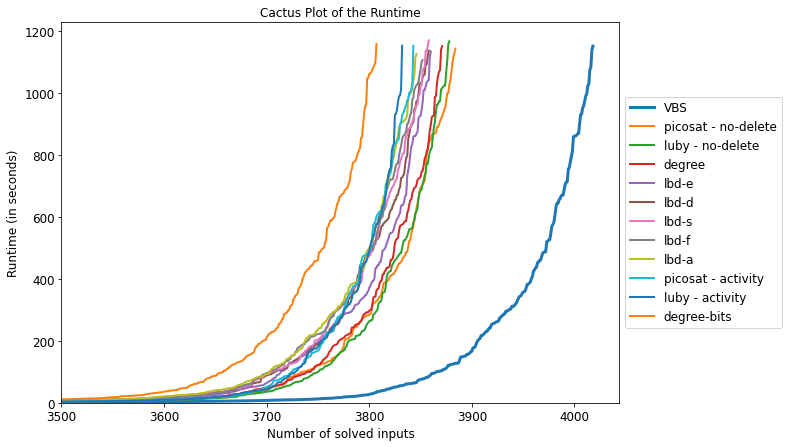

In [8]:
sat4j_restart.get_cactus_plot(cactus_col='cpu_time',
                              x_min=3500,
                                 
                              title='Cactus Plot of the Runtime',
                              y_axis_name="Runtime (in seconds)",
                              xp_ware_name_map=solver_map,
                              show_marker=False,

                              bbox_to_anchor=(1, 0.5),
                              legend_location='center left',

                              figsize=figsize,

                              dynamic=dynamic)

Let us now consider the cactus plot of the number of conflicts encountered by the solver, so as to get insights about the size of the proofs built by the different configurations considered here.

<AxesSubplot:title={'center':'Cactus Plot of the Number of Conflicts'}, xlabel='Number of solved inputs', ylabel='Number of Conflicts'>

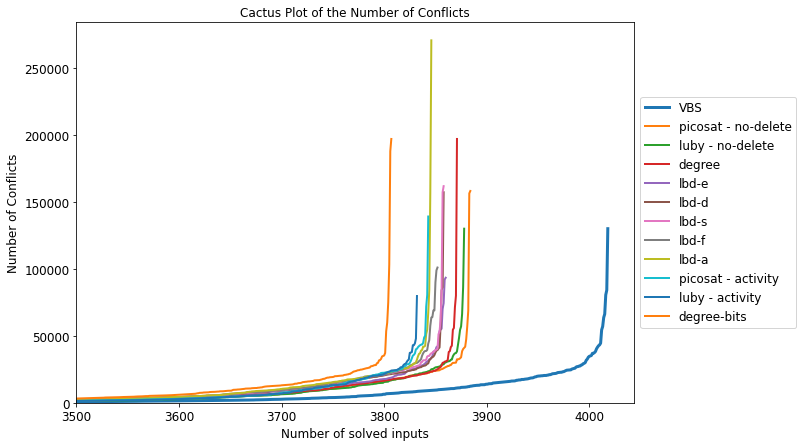

In [9]:
sat4j_restart.get_cactus_plot(cactus_col='conflicts',
                              x_min=3500,
                                 
                              title='Cactus Plot of the Number of Conflicts',
                              y_axis_name="Number of Conflicts",
                              xp_ware_name_map=solver_map,
                              show_marker=False,

                              bbox_to_anchor=(1, 0.5),
                              legend_location='center left',

                              figsize=figsize,

                              dynamic=dynamic)

A more precise view of the size of the proof may be obtained by looking at the number of cancellations performed
by the solver, instead of the number of conflicts.

<AxesSubplot:title={'center':'Cactus Plot of the Number of Cancellations'}, xlabel='Number of solved inputs', ylabel='Number of Cancellations'>

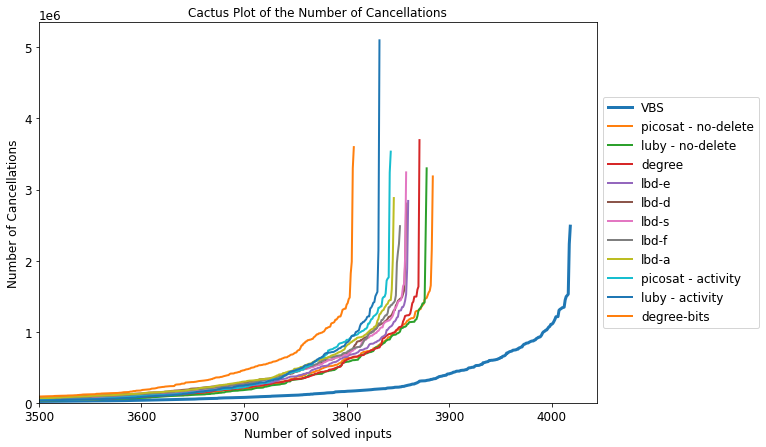

In [10]:
sat4j_restart.get_cactus_plot(cactus_col='steps',
                              x_min=3500,
                                   
                              title='Cactus Plot of the Number of Cancellations',
                              y_axis_name="Number of Cancellations",
                              xp_ware_name_map=solver_map,
                              show_marker=False,

                              bbox_to_anchor=(1, 0.5),
                              legend_location='center left',

                              figsize=figsize,

                              dynamic=dynamic)

## Pairwise Comparison of the Strategies

Let us now draw different scatter plots to get deeper insights on the behavior of the different strategies.

### Degree-Based Measures

<AxesSubplot:title={'center':'Comparison of picosat - no-delete and degree'}, xlabel='picosat - no-delete', ylabel='degree'>

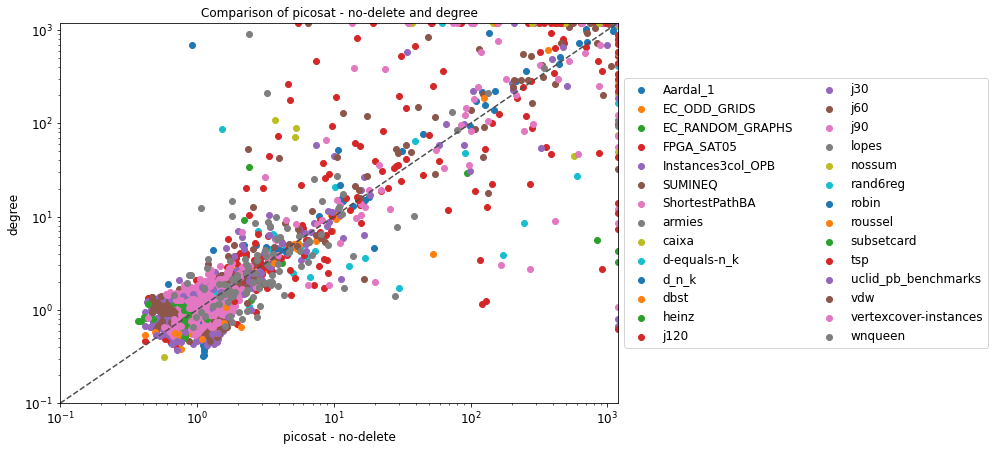

In [11]:
sat4j_restart.get_scatter_plot(xp_ware_x='restart-picosat-nodelete',
                               xp_ware_y='restart-degree',
                                      
                               color_col='family',
                               xp_ware_name_map=solver_map,

                               x_min=0.1, x_max=1200, logx=True,
                               y_min=0.1, y_max=1200, logy=True,

                               bbox_to_anchor=(1, 0.5),
                               legend_location='center left',
                               ncol_legend=2,

                               figsize=figsize,

                               dynamic=dynamic)  

<AxesSubplot:title={'center':'Comparison of picosat - no-delete and degree-bits'}, xlabel='picosat - no-delete', ylabel='degree-bits'>

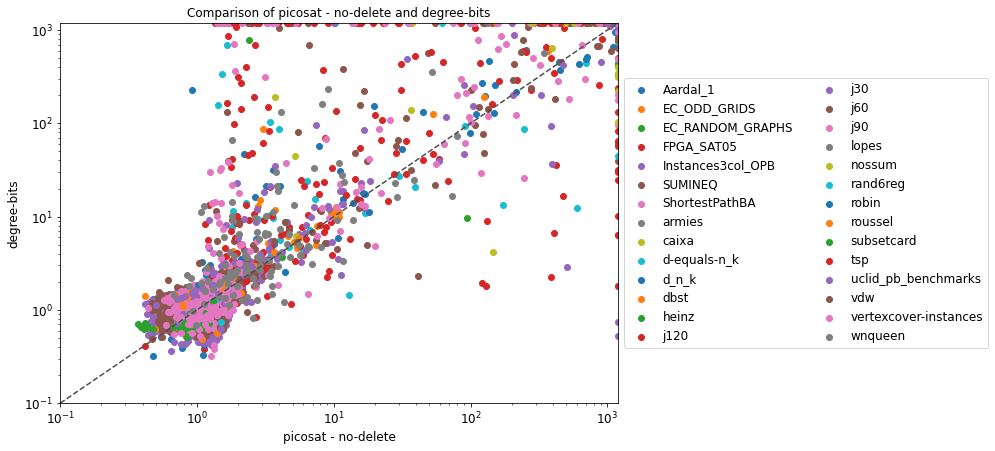

In [12]:
sat4j_restart.get_scatter_plot(xp_ware_x='restart-picosat-nodelete',
                               xp_ware_y='restart-degree-size',
                                      
                               color_col='family',
                               xp_ware_name_map=solver_map,

                               x_min=0.1, x_max=1200, logx=True,
                               y_min=0.1, y_max=1200, logy=True,

                               bbox_to_anchor=(1, 0.5),
                               legend_location='center left',
                               ncol_legend=2,

                               figsize=figsize,

                               dynamic=dynamic)  

### LBD-Based Measures

<AxesSubplot:title={'center':'Comparison of picosat - no-delete and lbd-a'}, xlabel='picosat - no-delete', ylabel='lbd-a'>

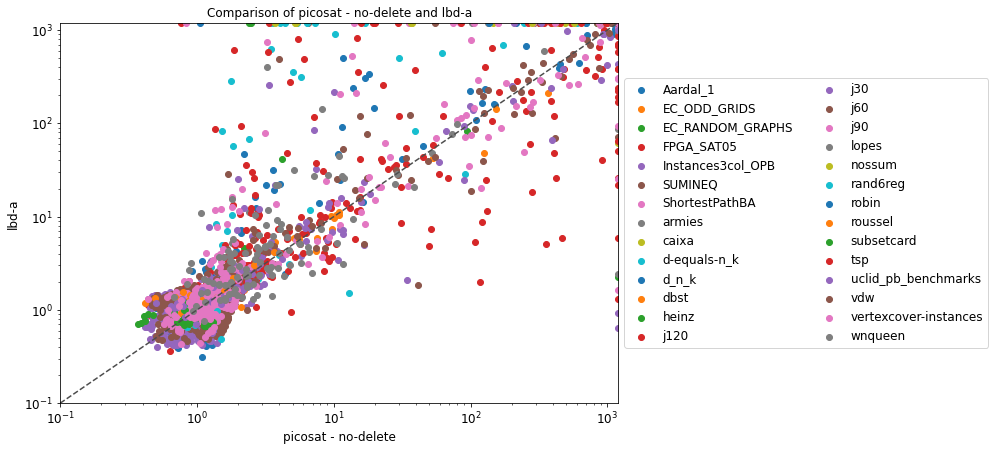

In [13]:
sat4j_restart.get_scatter_plot(xp_ware_x='restart-picosat-nodelete',
                               xp_ware_y='restart-assigned',
                                      
                               color_col='family',
                               xp_ware_name_map=solver_map,

                               x_min=0.1, x_max=1200, logx=True,
                               y_min=0.1, y_max=1200, logy=True,

                               bbox_to_anchor=(1, 0.5),
                               legend_location='center left',
                               ncol_legend=2,

                               figsize=figsize,

                               dynamic=dynamic)  

<AxesSubplot:title={'center':'Comparison of picosat - no-delete and lbd-e'}, xlabel='picosat - no-delete', ylabel='lbd-e'>

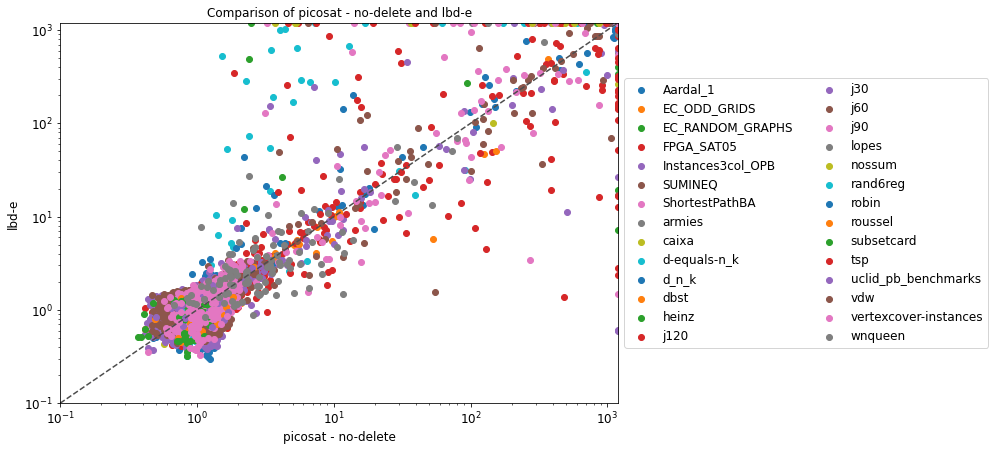

In [14]:
sat4j_restart.get_scatter_plot(xp_ware_x='restart-picosat-nodelete',
                               xp_ware_y='restart-effective',
                                      
                               color_col='family',
                               xp_ware_name_map=solver_map,

                               x_min=0.1, x_max=1200, logx=True,
                               y_min=0.1, y_max=1200, logy=True,

                               bbox_to_anchor=(1, 0.5),
                               legend_location='center left',
                               ncol_legend=2,

                               figsize=figsize,

                               dynamic=dynamic)  

<AxesSubplot:title={'center':'Comparison of picosat - no-delete and lbd-f'}, xlabel='picosat - no-delete', ylabel='lbd-f'>

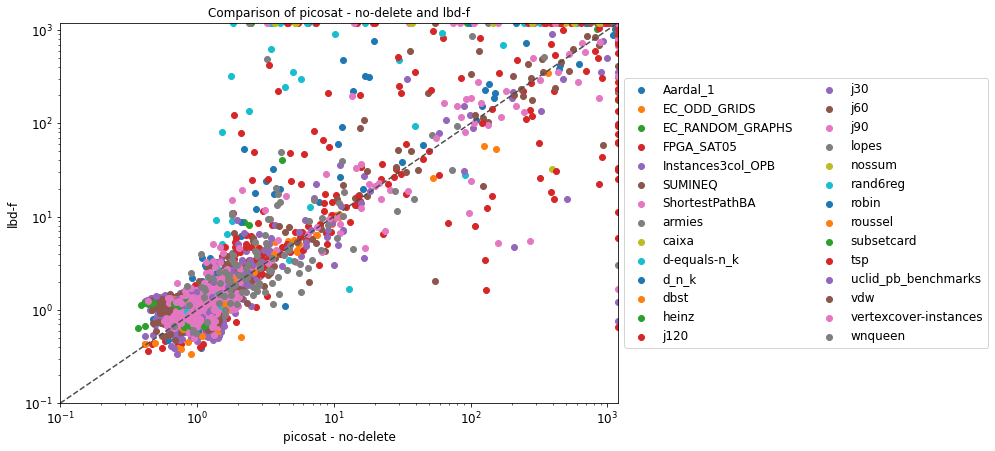

In [15]:
sat4j_restart.get_scatter_plot(xp_ware_x='restart-picosat-nodelete',
                               xp_ware_y='restart-falsified',
                                      
                               color_col='family',
                               xp_ware_name_map=solver_map,

                               x_min=0.1, x_max=1200, logx=True,
                               y_min=0.1, y_max=1200, logy=True,

                               bbox_to_anchor=(1, 0.5),
                               legend_location='center left',
                               ncol_legend=2,

                               figsize=figsize,

                               dynamic=dynamic)  

<AxesSubplot:title={'center':'Comparison of picosat - no-delete and lbd-d'}, xlabel='picosat - no-delete', ylabel='lbd-d'>

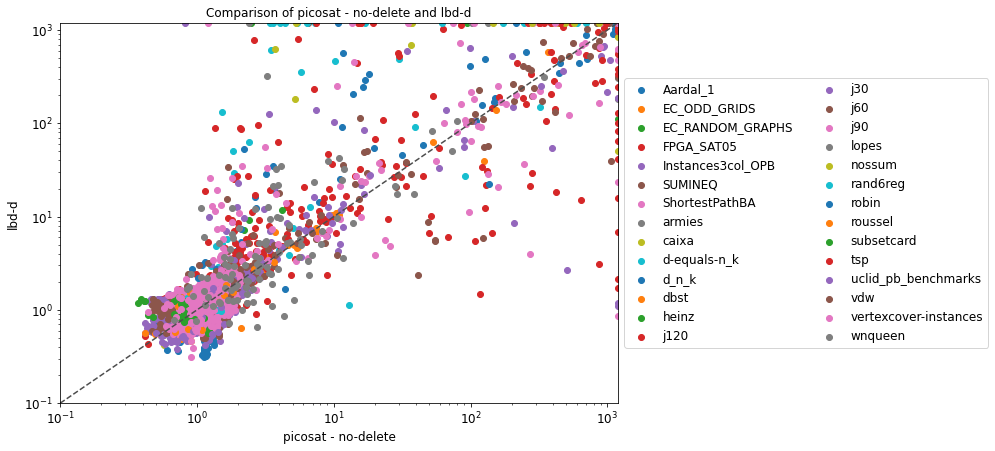

In [16]:
sat4j_restart.get_scatter_plot(xp_ware_x='restart-picosat-nodelete',
                               xp_ware_y='restart-unassigned-different',
                                      
                               color_col='family',
                               xp_ware_name_map=solver_map,

                               x_min=0.1, x_max=1200, logx=True,
                               y_min=0.1, y_max=1200, logy=True,

                               bbox_to_anchor=(1, 0.5),
                               legend_location='center left',
                               ncol_legend=2,

                               figsize=figsize,

                               dynamic=dynamic)  

<AxesSubplot:title={'center':'Comparison of picosat - no-delete and lbd-s'}, xlabel='picosat - no-delete', ylabel='lbd-s'>

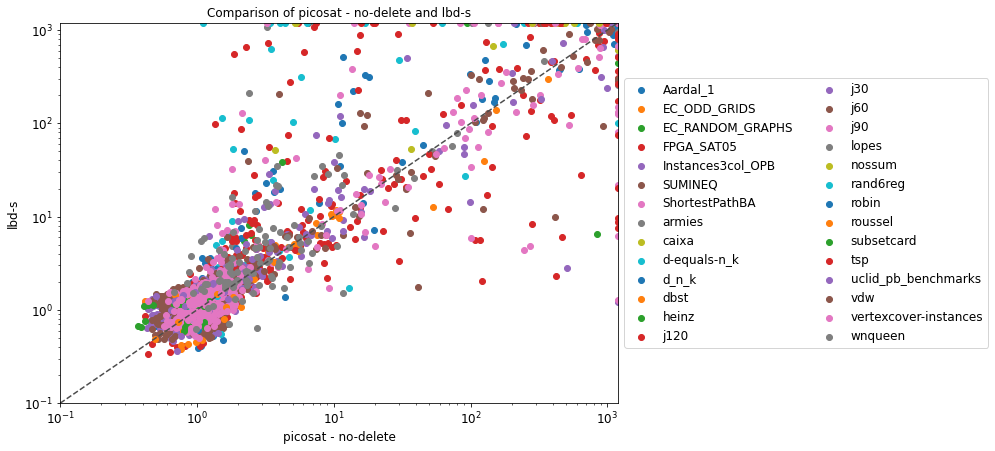

In [17]:
sat4j_restart.get_scatter_plot(xp_ware_x='restart-picosat-nodelete',
                               xp_ware_y='restart-unassigned-same',
                                      
                               color_col='family',
                               xp_ware_name_map=solver_map,

                               x_min=0.1, x_max=1200, logx=True,
                               y_min=0.1, y_max=1200, logy=True,

                               bbox_to_anchor=(1, 0.5),
                               legend_location='center left',
                               ncol_legend=2,

                               figsize=figsize,

                               dynamic=dynamic)  